# small slim tutorial

In [1]:
import os
import pyslim
import random
import numpy as np
import matplotlib.pyplot as plt

## function to run slim simulations

In [2]:
def slim_script(script, name, quiet=False):
    logfile = name + ".log"
    #out = os.system("echo '" + script + "' | slim > " + logfile + " 2>&1")
    #pipe not working for me, so make intermediate file and then run it
    scriptfile = name + ".slim"
    os.system("echo '" + script + "' > " + scriptfile)
    out = os.system("slim " + scriptfile + " > " + logfile + " 2>&1")
    if not quiet:
        with open(logfile, "r") as log:
            print(log.read())
    if out != 0:
        print("An error occurred.")
    return out, logfile

## neutral WF model 

In [118]:
neutral_WF = """
// set up a simple neutral simulation
initialize()
{

// set the overall mutation rate
 initializeMutationRate(1e-7);

// m1 mutation type: neutral
 initializeMutationType("m1", 0.5, "f", 0.0);

// g1 genomic element type: uses m1 for all mutations
 initializeGenomicElementType("g1", m1, 1.0);

// uniform chromosome of length 100 kb
 initializeGenomicElement(g1, 0, 99999);

// uniform recombination along the chromosome
 initializeRecombinationRate(1e-8);
}

// create a population of 500 individuals
1 {sim.addSubpop("p1", 500);}

// output sample of 10 haploid genomes after gen 5000
5000 late() { p1.outputSample(10); }

// output sample in MS form
// 5000 late() {p1.outputMSSample(10);}

// output sample in VCF form
// 5000 late () {p1.outputVCFSample(10);}

// run to generation 10000
10000 {sim.simulationFinished();}
"""

out, logfile = slim_script(neutral_WF, "neutral_WF")

// Initial random seed:
1568108037048

// RunInitializeCallbacks():
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 

#OUT: 5000 SS p1 10
Mutations:
12 36005 m1 72724 0 0.5 p1 3591 6
27 36033 m1 90562 0 0.5 p1 3594 4
25 36111 m1 82115 0 0.5 p1 3602 4
10 36821 m1 61029 0 0.5 p1 3674 6
20 36896 m1 30241 0 0.5 p1 3681 4
26 37408 m1 87668 0 0.5 p1 3729 4
11 37543 m1 68900 0 0.5 p1 3743 6
24 37745 m1 63390 0 0.5 p1 3760 4
6 38185 m1 36261 0 0.5 p1 3804 6
23 38888 m1 58313 0 0.5 p1 3876 4
3 39252 m1 21234 0 0.5 p1 3913 6
0 39451 m1 5507 0 0.5 p1 3934 6
4 40164 m1 23296 0 0.5 p1 4003 6
40 42624 m1 77169 0 0.5 p1 4242 2
16 43415 m1 92684 0 0.5 p1 4323 4
13 43840 m1 79632 0 0.5 p1 4363 4
7 44435 m1 38688 0 0.5 p1 4427 4
2 45832 m1 19790 0 0.5 p1 4570 4
1 46069 m1 14646 0 0.5 p1 4593 4
21 46136 m1 30307 0 0.5 p1 4601 

## neutral WF with tree sequence recording

In [122]:
neutral_WF_trees = """
// set up a simple neutral simulation
initialize()
{

// record trees
 initializeTreeSeq();

// set the overall mutation rate (overlay with msprime after)
 initializeMutationRate(0);

// m1 mutation type: neutral
 initializeMutationType("m1", 0.5, "f", 0.0);

// g1 genomic element type: uses m1 for all mutations
 initializeGenomicElementType("g1", m1, 1.0);

// uniform chromosome of length 100 kb
 initializeGenomicElement(g1, 0, 99999);

// uniform recombination along the chromosome
 initializeRecombinationRate(1e-8);
}

// create a population of 500 individuals
1 {sim.addSubpop("p1", 500);}

// output sample of 10 haploid genomes after gen 5000
// 5000 late() { p1.outputSample(10); }

// output sample in MS form
// 5000 late() {p1.outputMSSample(10);}

// output sample in VCF form
// 5000 late () {p1.outputVCFSample(10);}

// run to generation 10000
10000 {
  sim.simulationFinished();
  sim.treeSeqOutput("./neutral_WF_trees.trees");
  }
"""

out, logfile = slim_script(neutral_WF_trees, "neutral_WF_trees")

// Initial random seed:
1568178067345

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 




Now load tree sequence into python and plot coalescent times across the genome

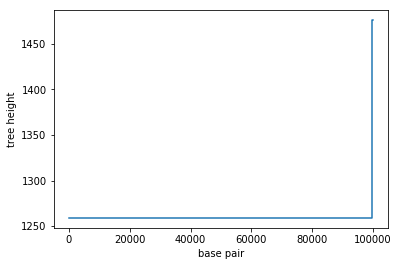

In [123]:
ts = pyslim.load("neutral_WF_trees.trees")

# Calculate tree heights, giving uncoalesced sites the maximum time
def tree_heights(ts):
	heights = np.zeros(ts.num_trees + 1)
	for tree in ts.trees():
		if tree.num_roots > 1: # not fully coalesced
			heights[tree.index] = ts.slim_generation
		else:
			children = tree.children(tree.root)
			real_root = tree.root if len(children) > 1 else children[0]
			heights[tree.index] = tree.time(real_root)
	heights[-1] = heights[-2] # repeat the last entry for plotting
	return heights

# Recapitate!
recap = ts.recapitate(recombination_rate=1e-8, Ne=500)

# Plot the tree heights after recapitation
breakpoints = list(recap.breakpoints())
heights = tree_heights(recap)
plt.step(breakpoints, heights, where='post')
#plt.yscale('log')
plt.xlabel('base pair')
plt.ylabel('tree height')
plt.show() 

## WF with selection

In [3]:
sweep_WF = """
initialize() {

        initializeTreeSeq();
        initializeMutationRate(0);
        initializeMutationType("m1", 0.5, "f", 0.0);
        initializeMutationType("m2", 0.5, "f", 0.1);
        initializeGenomicElementType("g1", m1, 1.0);
        initializeGenomicElement(g1,0,99999);
        initializeRecombinationRate(1e-7);
}

1 {
        defineConstant("simID", getSeed());
        sim.addSubpop("p1",500); }

1000 late() {
        sim.outputFull("/tmp/slim_" + simID + ".txt");
        target = sample(p1.genomes, 1);
        target.addNewDrawnMutation(m2, 50000);
}

1000:10000 late() {
        if (sim.countOfMutationsOfType(m2) == 0) {
                fixed = (sum(sim.substitutions.mutationType == m2) == 1);
                if (fixed) {
                        print(getSeed() + " fixed");
                        sim.simulationFinished();
                        sim.treeSeqOutput("./sweep_WF.trees");
                }
                else {
                        print(getSeed() + " lost -- restarting");
                        sim.readFromPopulationFile("/tmp/slim_" + simID + ".txt");
                        setSeed(getSeed() + 1);
                        target = sample(p1.genomes, 1);
                        target.addNewDrawnMutation(m2, 50000);
                }
        }
}
"""

out, logfile = slim_script(sweep_WF, "sweep_WF")

// Initial random seed:
1569979761018

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(2, 0.5, "f", 0.1);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-07);

// Starting run at generation <start>:
1 

"1569979761018 lost -- restarting"
"1569979761019 lost -- restarting"
"1569979761020 lost -- restarting"
"1569979761021 lost -- restarting"
"1569979761022 lost -- restarting"
"1569979761023 lost -- restarting"
"1569979761024 lost -- restarting"
"1569979761025 lost -- restarting"
"1569979761026 lost -- restarting"
"1569979761027 lost -- restarting"
"1569979761028 lost -- restarting"
"1569979761029 lost -- restarting"
"1569979761030 fixed"



now take a look at the coalescent times across the genome (note the switch to a log scale!)

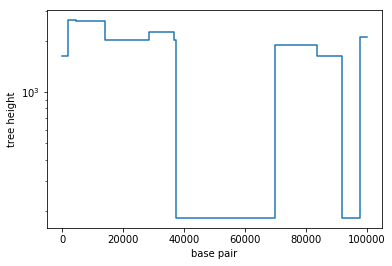

In [4]:
ts = pyslim.load("sweep_WF.trees")

# Calculate tree heights, giving uncoalesced sites the maximum time
def tree_heights(ts):
	heights = np.zeros(ts.num_trees + 1)
	for tree in ts.trees():
		if tree.num_roots > 1: # not fully coalesced
			heights[tree.index] = ts.slim_generation
		else:
			children = tree.children(tree.root)
			real_root = tree.root if len(children) > 1 else children[0]
			heights[tree.index] = tree.time(real_root)
	heights[-1] = heights[-2] # repeat the last entry for plotting
	return heights

# Recapitate!
recap = ts.recapitate(recombination_rate=1e-7, Ne=500)

# Plot the tree heights after recapitation
breakpoints = list(recap.breakpoints())
heights = tree_heights(recap)
plt.step(breakpoints, heights, where='post')
plt.yscale('log')
plt.xlabel('base pair')
plt.ylabel('tree height')
plt.show() 

## example of non-WF (evolutionary rescue sweep)

In [26]:
rescue_nonWF = """
initialize() {
    initializeSLiMModelType("nonWF"); //non Wright Fisher model
    initializeTreeSeq(); //record the tree
    
    defineConstant("N0", 1e4); //initial pop size (integer)
    defineConstant("d", 0.05); // wildtype decline rate [0,1]
    defineConstant("s", 0.2); //beneficial selection coefficient ([0,1]; s>d for rescue to be possible) 
    defineConstant("h", 0.5); //beneficial dominance [0,1]
    defineConstant("B", 2); //offspring per parent (positive integer; must be great than 1 for possible persistence) 
    defineConstant("L", 1e5 - 1); //number of sites (positive integer)
    defineConstant("L0", 5e4 - 1); //site number of beneficial locus (positive integer, L0<L)
    defineConstant("mu", 1e-5); //mutation rate at beneficial locus [0,1]
    defineConstant("r", 1e-7); //recombination rate per base pair [0,1]

    initializeMutationType("m1", h, "f", s); //beneficial mutation characteristics
    m1.mutationStackPolicy = "f"; //dont let beneficial mutations stack, instead keep first mutation (makes mutation origin clear; can still get soft sweeps)
    initializeMutationType("m2", 0.5, "f", 0.0); //neutral mutations (heritability has no affect)
    
    initializeGenomicElementType("g1", m1, 1.0); //define element g1 to have beneficial mutations
    initializeGenomicElementType("g2", m2, 1.0); //define element g2 to have neutral mutations
    initializeGenomicElement(g1, L0, L0); //element g1 is just one site
    initializeGenomicElement(g2, 0, L0 - 1); // element g2 is everything to the left...
    initializeGenomicElement(g2, L0 + 1, L); // ...and everything to the right of LO

    initializeMutationRate(c(0,mu,0), c(L0-1, L0, L)); //mutation rate per site (can set different rates for different blocks)
    initializeRecombinationRate(r); //recombination rate between sites 
}


// occurs right before early events, in this case right before census
reproduction() {
    for (i in 1:B) //B matings per parent
        subpop.addCrossed(individual, subpop.sampleIndividuals(1)); //random mating, 1 offspring per pair
}

// initialize population
1 early() {
    sim.addSubpop("p1", N0); //initialize population of wildtypes
    defineConstant("simID", getSeed()); //get the random seed to make sure any future runs use a different seed	
    sim.outputFull("/tmp/slim_" + simID + ".txt"); //output this initial state to use for future runs if needed
}

// census and update fitness
early() {
    inds = sim.subpopulations.individuals; //get info on all individuals
    inds[inds.age > 0].fitnessScaling = 0.0; //parents all die (discrete generations)
    off = inds[inds.age == 0]; //just focusing on offspring

    // hard carrying capacity by random culling
    N = length(off); //total number of offspring produced
    if (N>N0) { //if more than N0 (which we treat as carrying capacity)...
        indices = which(inds.age == 0); //get indices of offspring
        inds[sample(indices, N-N0)].fitnessScaling = 0.0; //kill a random subset to reduce N to N0
        off = inds[inds.fitnessScaling > 0]; //get surviving offspring
    }
    
    // census offspring
    N = length(off); //population size
    freq = sum(asInteger(off.genomes.countOfMutationsOfType(m1)>0))/(2*N); //frequency of beneficial mutation
    if (N==0) {
        print(sim.generation-1 + ": " + N); //print generation and population size
        print("extinction in generation " + (sim.generation-1) + " - RESTARTING");
        sim.readFromPopulationFile("/tmp/slim_" + simID + ".txt"); //reinitialize simulation
        setSeed(getSeed() + 1); //change random seed
    }
    else {       
        print(sim.generation-1 + ": " + N + ", " + freq); //print generation and population size and frequency
        if (freq == 1.0) {  //if mutation fixed
            print("rescue mutant fixes in generation " + (sim.generation-1.0));
            sim.simulationFinished(); //end simulation
            sim.treeSeqOutput("./rescue.trees"); //save tree sequence
        }
    }

    // fitness scaling
    p1.fitnessScaling = (1.0 - d)/B; //scale fitness so that wildtype has multiplicative growth rate B(1-d)/B = (1-d) 
}

// backup end simulation if runs too long
2000 late () {
    print("time is up, make max gens longer");
    sim.treeSeqOutput("./unfinished.trees");
    sim.simulationFinished();
}

"""

out, logfile = slim_script(rescue_nonWF, "rescue_nonWF", quiet=False)

// Initial random seed:
1570790284589

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeTreeSeq();
initializeMutationType(1, 0.5, "f", 0.2);
initializeMutationType(2, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElementType(2, m2, 1);
initializeGenomicElement(g1, 49999, 49999);
initializeGenomicElement(g2, 0, 49998);
initializeGenomicElement(g2, 50000, 99999);
initializeMutationRate(c(0, 1e-05, 0), c(49998, 49999, 99999));
initializeRecombinationRate(1e-07);
#WARNING (SLiMSim::RunInitializeCallbacks): with tree-sequence recording enabled and a non-zero mutation rate, a neutral mutation type was defined; this is legal, but usually undesirable, since neutral mutations can be overlaid later using the tree-sequence information.

// Starting run at generation <start>:
1 

"0: 10000, 0"
"1: 9532, 0"
"2: 9104, 0"
"3: 8618, 0"
"4: 8174, 0"
"5: 7600, 0"
"6: 7406, 0"
"7: 7138, 7.00476e-05"
"8: 6774, 0.000147623"
"9: 6418, 0"
"10: 6076